# TP3: Phase transitions in random k-SAT and random graph q-coloring
The purpose of this practical session is to let you 
* write generators of **uniform random k-SAT** formulae and **random q-coloring** problems, 
* observe phase transition phenomena and computation time when varying the **constraint density**, defined as the ratio between the number of clauses (resp. edges) over the number of variables (resp. vertices)
* empirically determine the **density thresholds of the unsat-sat transitions** in k-SAT and in k-coloring problems for k=3 and k=4.

In [1]:
import inf555

Obviously you will need to use  **Python's random library**

Have a look at the documentation for its peculiar capabilities like for **sampling elements**

In [2]:
import random

random.sample(range(5), 3)

[0, 2, 3]

Furthermore, here is a framework that you will use during the TP

* It first includes a `time_and_result` function
* taking a SAT instance as argument (with the syntax of TP2)
* sending it to a MiniZinc solver (chuffed by default)
* and returning the time taken (in fractional seconds) and the SAT/UNSAT result as a boolean

In [3]:
!vimcat.sh random_sat.py

import time
from typing import List, Set
import inf555

Var = int
Literal = int
Clause = Set[Literal]
Instance = List[Clause]


def literal_to_minizinc(lit: Literal) -> str:
    return ('not ' if lit < 0 else '') + f'vars[{str(abs(lit))}]'


def clause_to_minizinc(clause: Clause) -> str:
    return 'constraint ' + ' \\/ '.join(map(literal_to_minizinc, clause)) + ';'


def time_and_result(instance: Instance, solver=inf555.chuffed) -> (float, bool):
    '''send an instance to MiniZinc, time the execution.

    also return the satisfiability as a boolean'''
    # we consider that the highest variable appearing is our number of
    # variables
    nvar = max([abs(lit) for clause in instance for lit in clause])
    with open('sat.mzn', 'w') as f:
        print(f'array[1..{nvar}] of var bool: vars;', file=f)

        for clause in instance:
            print(clause_to_minizinc(clause), file=f)

    # get time from solutions.log instead?
    start = time.perf_counter()
    solution = inf555.m

In [4]:
import random_sat

In [5]:
random_sat.time_and_result([{1, -2, 3}, {1, -2, -3}])

(0.20451969999999164, True)

In [6]:
random_sat.time_and_result([{1, -2, 3}, {1, -2, -3}, {-1}, {2}])

(0.10348970000001145, False)

---

Now some useful bits:

- how to create (plottable) arrays using "numpy" (`inf555.np`)
- how to sample random integers using "numpy"
- how to plot something using "matplotlib.plot" (`inf555.plt`)

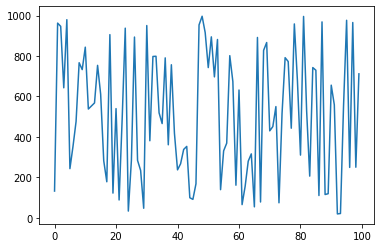

In [7]:
# create an array of indices from 0 to 99
x = inf555.np.arange(0, 100)
# create an array of size 100 with random integers sampled between 0 and 999
y = inf555.np.random.randint(0, 1000, size=100)
# plot y by x
inf555.plt.plot(x, y)

Done with preliminaries, now get down to work!

# Part I - Generator of Random k-CNF formulae
Let us consider formulae in Conjunctive Normal Form 
* over **N variables**
* with **exactly k litterals per clause** without repetition nor complement
* and d.N clauses, i.e. **constraint density d** as number of clauses over number of variables

## Question 1. Define the procedures
* generate_clause(int: k, int: N)
* generate_CNF(int: k, int: N, float: d)
* statistics(int: r, int: k, int: N, float: d)
* plot of statistics for varying density d

by completing the following cells

In [16]:
# These are Python3 type-annotations
# for a Boolean formula in Conjunctive Normal Form
# written as a list of sets of litterals syntax (TP2 syntax)
from typing import List, Set
Var = int
Literal = int
Clause = Set[Literal]
Instance = List[Clause]

# generate one random k-clause over N variables without repetition nor complement literal
def generate_clause(k: int, N: int) -> Clause:
    c = []
    for i in range(k):
        ci = 0
        while (ci ==0 or (ci in c) or (-ci in c)):
            ci = inf555.np.random.randint(-N, N)
        c.append(ci)
    clause = set(c)
    return clause;

In [21]:
# test

k = 10
N = 1500
for i in range(10000):
    clause_random = generate_clause(k,N)
    l = list(clause_random)
    for i in l:
        if -i in l:
            print(l,i)
            print('complement error')
    if len(l) != k:
        print(l)
        print('length error')
        
print('Test pass')


Test pass


In [27]:
import math
# generate one random k-CNF formula of d.N clauses over N variables
def generate_CNF(k: int, N: int, d: float) -> Instance:
    num_c = math.ceil(d*N)
    instance = []
    for i in range(num_c):
        instance.append(generate_clause(k,N))
    
    return instance;

In [29]:
# test
k = 3
N = 150
for i in range(1,100):
    d = i/25
    instance = generate_CNF(k,N,d)
    if abs(len(instance)/N - d) > 0.01:
        print('length error')

print('test pass')

test pass


In [33]:
import statistics as stats

# generate the mean satisfiability and mean computation time
# of r random k-CNF formulae with N variables and density d
def statistics(r: int, k: int, N: int, d: float) -> (float, float):
    num_pass = 0
    sum_time = 0
    for i in range(r):
        instance = generate_CNF(k,N,d)
        time , f = random_sat.time_and_result(instance)
        if f:
            num_pass += 1
        sum_time += time
    return (num_pass/r, sum_time/r)


In [34]:
# test
k = 3
N = 150
d = 4
for r in range(10,15):
    print(statistics(r,k,N,d))


(0.9, 0.14952608999992661)
(1.0, 0.14303477272716753)
(1.0, 0.14739831666664335)
(0.9230769230769231, 0.14914640769228965)
(1.0, 0.13934011428575235)


In [55]:
# generate statistics by varying the density
# from d1=2^k/k (remember the course!) to d2=2^k in 20 steps 
# and plot the results of mean satisfiability and mean computation time
def density_statistics_plot(r: int, k: int, N: int) -> float:
    steps = 20
    d1 = 2**k/k
    dt = (2**k - d1)/steps
    l_prob = []
    l_time = []
    x=[]
    for i in range(steps):
        d = d1+dt*i
        prob,time = statistics(r,k,N,d)
        x.append(d)
        l_prob.append(prob)
        l_time.append(time)
        
    
    fig, axs = inf555.plt.subplots(2, 1)
    axs[0].plot(x,l_prob,'-')
    axs[0].set_title('Prob')
    axs[0].set_xlabel('density(C/N)')
    axs[0].set_ylabel('Prob(SAT)')

    axs[1].plot(x,l_time, '--')
    axs[1].set_xlabel('density(C/N)')
    axs[1].set_title('Time')
    axs[1].set_ylabel('Time')

    inf555.plt.show()

### plot the results 
for r=10, k=3,4, N=25,75


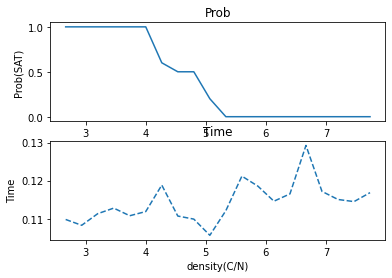

In [56]:
density_statistics_plot(10,3,25)

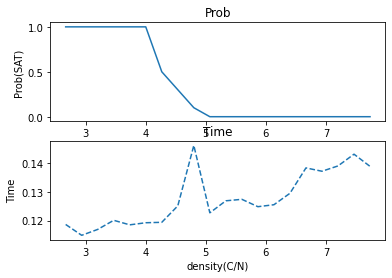

In [57]:
density_statistics_plot(10,3,75)

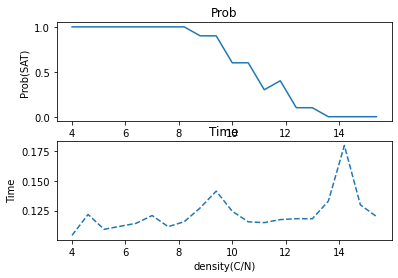

In [58]:
density_statistics_plot(10,4,25)

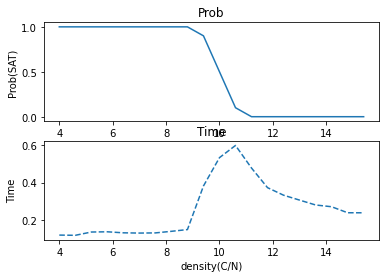

In [59]:
density_statistics_plot(10,4,75)

## Question 2. Determine the phase transition thresholds of k-SAT problems 
for k=3: d is around 4

and k=4: d is around 9



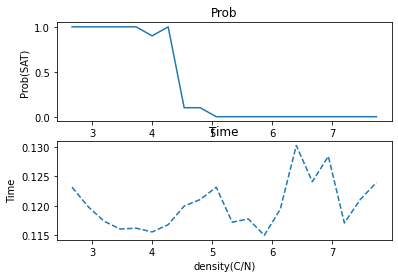

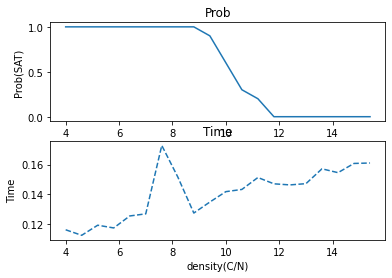

In [60]:
density_statistics_plot(10,3,50)
density_statistics_plot(10,4,50)

# Part II - Graph q-Coloring Problems 

Let us consider again the graph q-coloring MiniZinc model of TP1 and TP2 illustrated by the coloring of the Australian map.

We will
* generate random q-coloring problems in that format
* and use the same MiniZinc model to solve them, still using the Chuffed boolean constraint solver.

In [61]:
!vimcat.sh aust_param.dzn

Vertices = {wa, nt, sa, q, nsw, v};
NbEdges = 1..9;
Edges1 = [wa, wa, nt, nt, sa, sa, sa, q, nsw];
Edges2 = [nt, sa, sa, q, q, nsw, v, nsw, v];


In [62]:
!vimcat.sh aust_param.mzn

int: nc;
enum Vertices;
set of int: NbEdges;
array[NbEdges] of Vertices: Edges1;
array[NbEdges] of Vertices: Edges2;

array[Vertices] of var int: Color;
constraint forall (color in Color)(color >=0 /\ color < nc);
constraint forall (n in NbEdges)(Color[Edges1[n]] != Color[Edges2[n]]);

solve satisfy;


In [63]:
print(inf555.minizinc('aust_param.mzn', 'aust_param.dzn', data={'nc': 3}, 
                      solver=inf555.chuffed))

Solution(Color=[2, 1, 0, 2, 1, 2], _checker='')


## Question 3. Write Python code to generate uniform random graph q-coloring problems in MiniZinc syntax

We consider a uniform random graph model with density d, i.e. composed of

* N vertices 
* d.N random edges uniformly distributed among vertices

We wish to analyze the q-coloriability of such random graphs.

## Question 4. What do you observe in q-coloring problem in that uniform random graph model ?

Perform an empirical analysis of COLorable/UNCOLorable transitions for 
* q=3: density threshold estimated to ...
* q=4: density threshold estimated to ...
* q=5: density threshold estimated to ...